# Training an Anomalous Jet Detector with **Conv 2D** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet image into a low-dimension laten space and, from there, reconstruct the input image. The distance between the input and te output is used to identify rare jet configurations. Applying a lower treshold on the loss, one can veto standard QCD jets (quarks and gluons) and select a sample enriched in anomalous jets (W, Z, top, etc). The model uses (De)Conv2D and Dense layers to process the image.

This is based on the following papers:
- https://arxiv.org/pdf/1808.08992.pdf
- https://arxiv.org/pdf/1808.08979.pdf

For details on the dataset, see Notebook1 and Notebook3

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [ ]:
! git clone https://github.com/pierinim/tutorials.git

In [3]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [4]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetImage.shape)

Appending tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [5]:
jetImage = jetImage.reshape((jetImage.shape[0], jetImage.shape[1], jetImage.shape[2], 1))
print(jetImage.shape)

(50000, 100, 100, 1)


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [6]:
jetImage_standard = jetImage[np.argmax(target,axis=1)<2]
jetImage_W = jetImage[np.argmax(target,axis=1)==2]
jetImage_Z = jetImage[np.argmax(target,axis=1)==3]
jetImage_t = jetImage[np.argmax(target,axis=1)==4]
print(jetImage_standard.shape, jetImage_W.shape, jetImage_Z.shape, jetImage_t.shape)

(19908, 100, 100, 1) (10015, 100, 100, 1) (10037, 100, 100, 1) (10040, 100, 100, 1)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [7]:
label_standard = target[np.argmax(target,axis=1)<2]
del target

We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, label_train, label_val = t= train_test_split(jetImage_standard, label_standard, test_size=0.5)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape)
len_val = X_val.shape[0]
X_test = X_val[int(len_val/2.):,:,:,:]
label_test = label_val[int(len_val/2.):,:]
X_val = X_val[:int(len_val/2.),:,:,:]
label_test = label_val[:int(len_val/2.),:]
print(X_train.shape, X_val.shape, X_test.shape, label_train.shape, label_val.shape, label_test.shape)

(9954, 100, 100, 1) (9954, 100, 100, 1) (9954, 5) (9954, 5)
(9954, 100, 100, 1) (4977, 100, 100, 1) (4977, 100, 100, 1) (9954, 5) (9954, 5) (4977, 5)


In [9]:
# some cleanup to save memory
del jetImage, jetImage_standard

# Building the ConvAE model

In [10]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Flatten, Activation, Deconv2D
from keras.layers import MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
image_shape = (img_rows, img_cols, 1)

In [12]:
#---------
# Enncoder
#---------
inputImage = Input(shape=(image_shape))
#
x = Conv2D(10, kernel_size=(5, 5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5, 5))(x)
#
x = Conv2D(15, kernel_size=(4, 4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5, 5))(x)
#
x = Conv2D(20, kernel_size=(4, 4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (4, 4))(x)
#
x = Flatten()(x)
enc = Dense(5, activation='relu')(x)

#---------
# Decoder
#---------

x = Dense(20, activation='relu')(enc)
x = Reshape((1, 1, 20))(x)
#
x = UpSampling2D((4, 4))(x)
x = BatchNormalization()(x)
x = Deconv2D(15, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = Activation('relu')(x)
#
x = UpSampling2D((5, 5))(x)
x = BatchNormalization()(x)
x = Deconv2D(10, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = Activation('relu')(x)
#
x = UpSampling2D((5, 5))(x)
x = BatchNormalization()(x)
x = Deconv2D(1, kernel_size=(4,4), data_format="channels_last", strides=(1, 1), padding="same")(x)
dec = Activation('relu')(x)
#output = Deconv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(x)
####
autoencoder = Model(inputs=inputImage, outputs=dec)

In [13]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 10)      260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 10)      40        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 10)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 15)        2415      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 15)        60        
__________

We now train the model. Notice the difference with respect to the supervised case
- the input to the training is (X,X) and nor (X, y). Similarly for the validation dataset
- the model has no dropout. It is difficult for an unsupervised model to overtran, so there is not really a need

In [14]:
batch_size = 128
n_epochs = 1

In [15]:
# train 
history = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 9954 samples, validate on 4977 samples
Epoch 1/1
 - 104s - loss: 33.2695 - val_loss: 33.0239


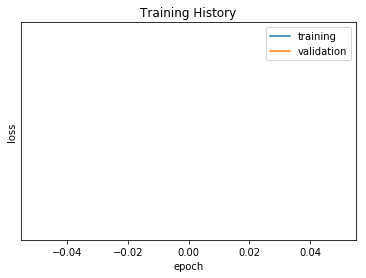

In [16]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We save on disk the best model, result of the training, to be then use for inference

In [ ]:
model_json = autoencoder.to_json()
with open("tutorials/HiggsSchool/models/jetAE_Conv2D.json", "w") as json_file:
    json_file.write(model_json)
autoencoder.save_weights("tutorials/HiggsSchool/models/jetAE_Conv2D.h5")

# Loss Distributions

In [17]:
labels = ['W', 'Z', 'top']

In [18]:
anomaly = [jetImage_W, jetImage_Z, jetImage_t]
predictedQCD = autoencoder.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(autoencoder.predict(anomaly[i]))

In [19]:
def mse(image_in, image_out):
    mse = (image_out-image_in)*(image_out-image_in)
    # sum over channel
    mse = np.sum(mse,axis=-1)
    # sum over y
    mse = np.sum(mse, axis=-1)
    # sum over x
    mse = np.sum(mse, axis=-1)
    return mse    

In [20]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

In [21]:
lossQCD_1 = lossQCD

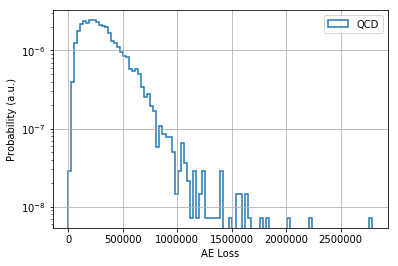

In [23]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD_1, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()